# 🌱 Analyse Saisonnière des Ratings d'Ingrédients

## Objectif
Analyser les variations saisonnières dans l'appréciation des ingrédients pour identifier :
- Les ingrédients avec des préférences saisonnières marquées
- Les patterns de consommation selon les saisons
- Les opportunités de menu saisonnier

## Méthodologie
- **Test statistique** : ANOVA pour comparer les moyennes entre saisons
- **Post-hoc** : Test de Tukey pour identifier les différences par paires
- **Agrégation** : Ratings moyens par saison et ingrédient
- **Visualisation** : Box plots et radar charts saisonniers
- **Seuil de significativité** : p < 0.05

## Définition des Saisons
- **Printemps** : Mars, Avril, Mai
- **Été** : Juin, Juillet, Août  
- **Automne** : Septembre, Octobre, Novembre
- **Hiver** : Décembre, Janvier, Février

In [ ]:
# Import des bibliothèques nécessaires
import sys
sys.path.append('..')

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour les saisons
SEASON_COLORS = {
    'Printemps': '#90EE90',  # Vert clair
    'Été': '#FFD700',        # Jaune doré
    'Automne': '#FF8C00',    # Orange
    'Hiver': '#87CEEB'       # Bleu ciel
}

print("📚 Toutes les bibliothèques importées avec succès !")
print("🌱 Analyse saisonnière prête à démarrer !")

📚 Toutes les bibliothèques importées avec succès !
🌱 Analyse saisonnière prête à démarrer !


In [4]:
# Fonction pour mapper les mois aux saisons
def get_season(month):
    """
    Convertit un numéro de mois en saison
    """
    if month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    elif month in [9, 10, 11]:
        return 'Automne'
    else:  # [12, 1, 2]
        return 'Hiver'

print('✅ Fonction de mapping saisons définie')

✅ Fonction de mapping saisons définie


In [5]:
# Chargement des données pour analyse saisonnière
print('🔄 Chargement des données...')

# Ingrédients cibles pour l'analyse saisonnière (présents dans les 4 saisons)
target_ingredients = get_ingredients_for_analysis('seasonality')
print(f'📋 Ingrédients sélectionnés: {target_ingredients}')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Ajout de la colonne saison
df = df.with_columns([
    pl.col('date').dt.month().alias('month')
]).with_columns([
    pl.col('month').map_elements(get_season, return_dtype=pl.Utf8).alias('season')
])

print('\n📊 Distribution par saison:')
season_dist = df.group_by('season').agg(pl.len().alias('count')).sort('count', descending=True)
print(season_dist)

print('\n📊 Aperçu des données avec saisons:')
print(df.select(['date', 'month', 'season', 'ingredient_name', 'rating']).head())

🔄 Chargement des données...
📋 Ingrédients sélectionnés: ['salt', 'ground beef', 'eggs', 'onions', 'garlic', 'butternut squash', 'asparagus', 'pumpkin']
✅ Données chargées: 845,309 interactions pour 8 ingrédients
✅ Dataset chargé: 845,309 interactions
📅 Période: 2000-01-25 → 2018-12-20

📊 Distribution par saison:
shape: (4, 2)
┌───────────┬────────┐
│ season    ┆ count  │
│ ---       ┆ ---    │
│ str       ┆ u32    │
╞═══════════╪════════╡
│ Hiver     ┆ 224373 │
│ Automne   ┆ 213140 │
│ Printemps ┆ 209557 │
│ Été       ┆ 198239 │
└───────────┴────────┘

📊 Aperçu des données avec saisons:
shape: (5, 5)
┌────────────┬───────┬───────────┬─────────────────┬────────┐
│ date       ┆ month ┆ season    ┆ ingredient_name ┆ rating │
│ ---        ┆ ---   ┆ ---       ┆ ---             ┆ ---    │
│ date       ┆ i8    ┆ str       ┆ str             ┆ i64    │
╞════════════╪═══════╪═══════════╪═════════════════╪════════╡
│ 2000-01-25 ┆ 1     ┆ Hiver     ┆ salt            ┆ 4      │
│ 2000-01-25 ┆ 1    

In [6]:
# Agrégation des données par saison et ingrédient
print('🔧 Agrégation des données saisonnières...')

df_seasonal = df.group_by(['ingredient_name', 'season']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'season'])

print(f'✅ Données agrégées: {df_seasonal.shape[0]} points saison-ingrédient')

# Vérification de la couverture saisonnière par ingrédient
season_coverage = df_seasonal.group_by('ingredient_name').agg([
    pl.col('season').n_unique().alias('seasons_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\n📈 Couverture saisonnière par ingrédient:')
print(season_coverage)

# Filtrer les ingrédients avec couverture complète (4 saisons)
complete_ingredients = season_coverage.filter(
    pl.col('seasons_covered') == 4
)['ingredient_name'].to_list()

print(f'\n🎯 Ingrédients avec couverture complète (4 saisons): {len(complete_ingredients)}')
print(f'Ingrédients: {complete_ingredients}')

🔧 Agrégation des données saisonnières...
✅ Données agrégées: 32 points saison-ingrédient

📈 Couverture saisonnière par ingrédient:
shape: (8, 3)
┌──────────────────┬─────────────────┬───────────────┐
│ ingredient_name  ┆ seasons_covered ┆ total_ratings │
│ ---              ┆ ---             ┆ ---           │
│ str              ┆ u32             ┆ u32           │
╞══════════════════╪═════════════════╪═══════════════╡
│ salt             ┆ 4               ┆ 468403        │
│ eggs             ┆ 4               ┆ 178000        │
│ garlic           ┆ 4               ┆ 102506        │
│ onions           ┆ 4               ┆ 48041         │
│ ground beef      ┆ 4               ┆ 37195         │
│ pumpkin          ┆ 4               ┆ 4154          │
│ asparagus        ┆ 4               ┆ 3781          │
│ butternut squash ┆ 4               ┆ 3229          │
└──────────────────┴─────────────────┴───────────────┘

🎯 Ingrédients avec couverture complète (4 saisons): 8
Ingrédients: ['salt', 'eggs', 

In [8]:
# Test ANOVA pour détecter les différences saisonnières
print('🔍 Test ANOVA pour les différences saisonnières...')

anova_results = []

for ingredient in complete_ingredients:
    # Données pour cet ingrédient par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par saison
    spring_ratings = ingredient_data.filter(pl.col('season') == 'Printemps')['rating'].to_list()
    summer_ratings = ingredient_data.filter(pl.col('season') == 'Été')['rating'].to_list()
    autumn_ratings = ingredient_data.filter(pl.col('season') == 'Automne')['rating'].to_list()
    winter_ratings = ingredient_data.filter(pl.col('season') == 'Hiver')['rating'].to_list()
    
    # Test ANOVA
    if all(len(ratings) > 0 for ratings in [spring_ratings, summer_ratings, autumn_ratings, winter_ratings]):
        f_stat, p_value = f_oneway(spring_ratings, summer_ratings, autumn_ratings, winter_ratings)
        
        # Calcul des moyennes par saison
        season_means = {
            'spring_mean': np.mean(spring_ratings),
            'summer_mean': np.mean(summer_ratings),
            'autumn_mean': np.mean(autumn_ratings),
            'winter_mean': np.mean(winter_ratings)
        }
        
        # Identification de la meilleure et pire saison
        best_season = max(season_means, key=season_means.get).replace('_mean', '')
        worst_season = min(season_means, key=season_means.get).replace('_mean', '')
        
        anova_results.append({
            'ingredient': ingredient,
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,  # Booléen pur
            'spring_avg': season_means['spring_mean'],
            'summer_avg': season_means['summer_mean'],
            'autumn_avg': season_means['autumn_mean'],
            'winter_avg': season_means['winter_mean'],
            'best_season': best_season.title(),
            'worst_season': worst_season.title(),
            'seasonal_range': max(season_means.values()) - min(season_means.values())
        })

# Conversion en DataFrame Polars
anova_df = pl.DataFrame(anova_results).sort('p_value')

print('\n📊 Résultats ANOVA pour les différences saisonnières:')
print(anova_df.select(['ingredient', 'f_statistic', 'p_value', 'significant', 'best_season', 'seasonal_range']))

# Résumé des différences significatives
significant_seasonal = anova_df.filter(pl.col('significant') == True)
print(f'\n🎯 Ingrédients avec variations saisonnières significatives: {len(significant_seasonal)}/{len(complete_ingredients)}')

if len(significant_seasonal) > 0:
    print('\nVariations saisonnières significatives:')
    for row in significant_seasonal.iter_rows(named=True):
        print(f"🌱 {row['ingredient']}: Meilleure saison = {row['best_season']} " +
              f"(amplitude = {row['seasonal_range']:.4f}, p={row['p_value']:.4f})")
else:
    print('➡️ Aucune variation saisonnière significative détectée')

🔍 Test ANOVA pour les différences saisonnières...

📊 Résultats ANOVA pour les différences saisonnières:
shape: (8, 6)
┌──────────────────┬─────────────┬────────────┬─────────────┬─────────────┬────────────────┐
│ ingredient       ┆ f_statistic ┆ p_value    ┆ significant ┆ best_season ┆ seasonal_range │
│ ---              ┆ ---         ┆ ---        ┆ ---         ┆ ---         ┆ ---            │
│ str              ┆ f64         ┆ f64        ┆ f64         ┆ str         ┆ f64            │
╞══════════════════╪═════════════╪════════════╪═════════════╪═════════════╪════════════════╡
│ salt             ┆ 20.120032   ┆ 4.9332e-13 ┆ 1.0         ┆ Summer      ┆ 0.040196       │
│ eggs             ┆ 5.18711     ┆ 0.001395   ┆ 1.0         ┆ Summer      ┆ 0.035252       │
│ garlic           ┆ 4.827921    ┆ 0.002316   ┆ 1.0         ┆ Spring      ┆ 0.033814       │
│ ground beef      ┆ 3.606619    ┆ 0.012749   ┆ 1.0         ┆ Summer      ┆ 0.057198       │
│ butternut squash ┆ 1.92254     ┆ 0.123708  

In [9]:
# Analyse détaillée par paires pour les ingrédients significatifs
print('🔍 Tests par paires (Mann-Whitney U) pour les différences saisonnières...')

from scipy.stats import mannwhitneyu

tukey_results = {}

for ingredient in significant_seasonal['ingredient'].to_list():
    print(f'\n📊 Analyse détaillée pour {ingredient}:')
    
    # Préparation des données par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    seasons = ['Printemps', 'Été', 'Automne', 'Hiver']
    season_data = {}
    
    for season in seasons:
        season_ratings = ingredient_data.filter(pl.col('season') == season)['rating'].to_list()
        season_data[season] = season_ratings
        print(f"   {season}: {len(season_ratings)} ratings, moyenne = {np.mean(season_ratings):.4f}")
    
    # Test par paires avec Mann-Whitney U
    print(f'\n   🔍 Comparaisons par paires significatives (p<0.05):')
    significant_pairs = []
    
    for i, season1 in enumerate(seasons):
        for j, season2 in enumerate(seasons[i+1:], i+1):
            try:
                u_stat, p_value = mannwhitneyu(season_data[season1], season_data[season2], alternative='two-sided')
                if p_value < 0.05:
                    mean_diff = np.mean(season_data[season1]) - np.mean(season_data[season2])
                    direction = '>' if mean_diff > 0 else '<'
                    significant_pairs.append(f"   → {season1} {direction} {season2}: Δ={mean_diff:+.4f} (p={p_value:.4f})")
            except Exception as e:
                continue
    
    if significant_pairs:
        for pair in significant_pairs:
            print(pair)
    else:
        print('   → Aucune différence par paires significative détectée')
    
    tukey_results[ingredient] = significant_pairs

print(f'\n✅ Tests par paires terminés pour {len(tukey_results)} ingrédients')

🔍 Tests par paires (Mann-Whitney U) pour les différences saisonnières...

📊 Analyse détaillée pour salt:
   Printemps: 115611 ratings, moyenne = 4.3938
   Été: 112107 ratings, moyenne = 4.4103
   Automne: 116457 ratings, moyenne = 4.3828
   Hiver: 124228 ratings, moyenne = 4.3701

   🔍 Comparaisons par paires significatives (p<0.05):
   → Printemps < Été: Δ=-0.0165 (p=0.0001)
   → Printemps > Automne: Δ=+0.0110 (p=0.0450)
   → Printemps > Hiver: Δ=+0.0237 (p=0.0134)
   → Été > Automne: Δ=+0.0275 (p=0.0000)
   → Été > Hiver: Δ=+0.0402 (p=0.0000)

📊 Analyse détaillée pour eggs:
   Printemps: 44683 ratings, moyenne = 4.3581
   Été: 39859 ratings, moyenne = 4.3718
   Automne: 45231 ratings, moyenne = 4.3495
   Hiver: 48227 ratings, moyenne = 4.3365

   🔍 Comparaisons par paires significatives (p<0.05):
   → Printemps > Hiver: Δ=+0.0216 (p=0.0058)
   → Été > Automne: Δ=+0.0222 (p=0.0078)
   → Été > Hiver: Δ=+0.0353 (p=0.0003)

📊 Analyse détaillée pour garlic:
   Printemps: 25986 ratings, mo

📊 Création des visualisations saisonnières...


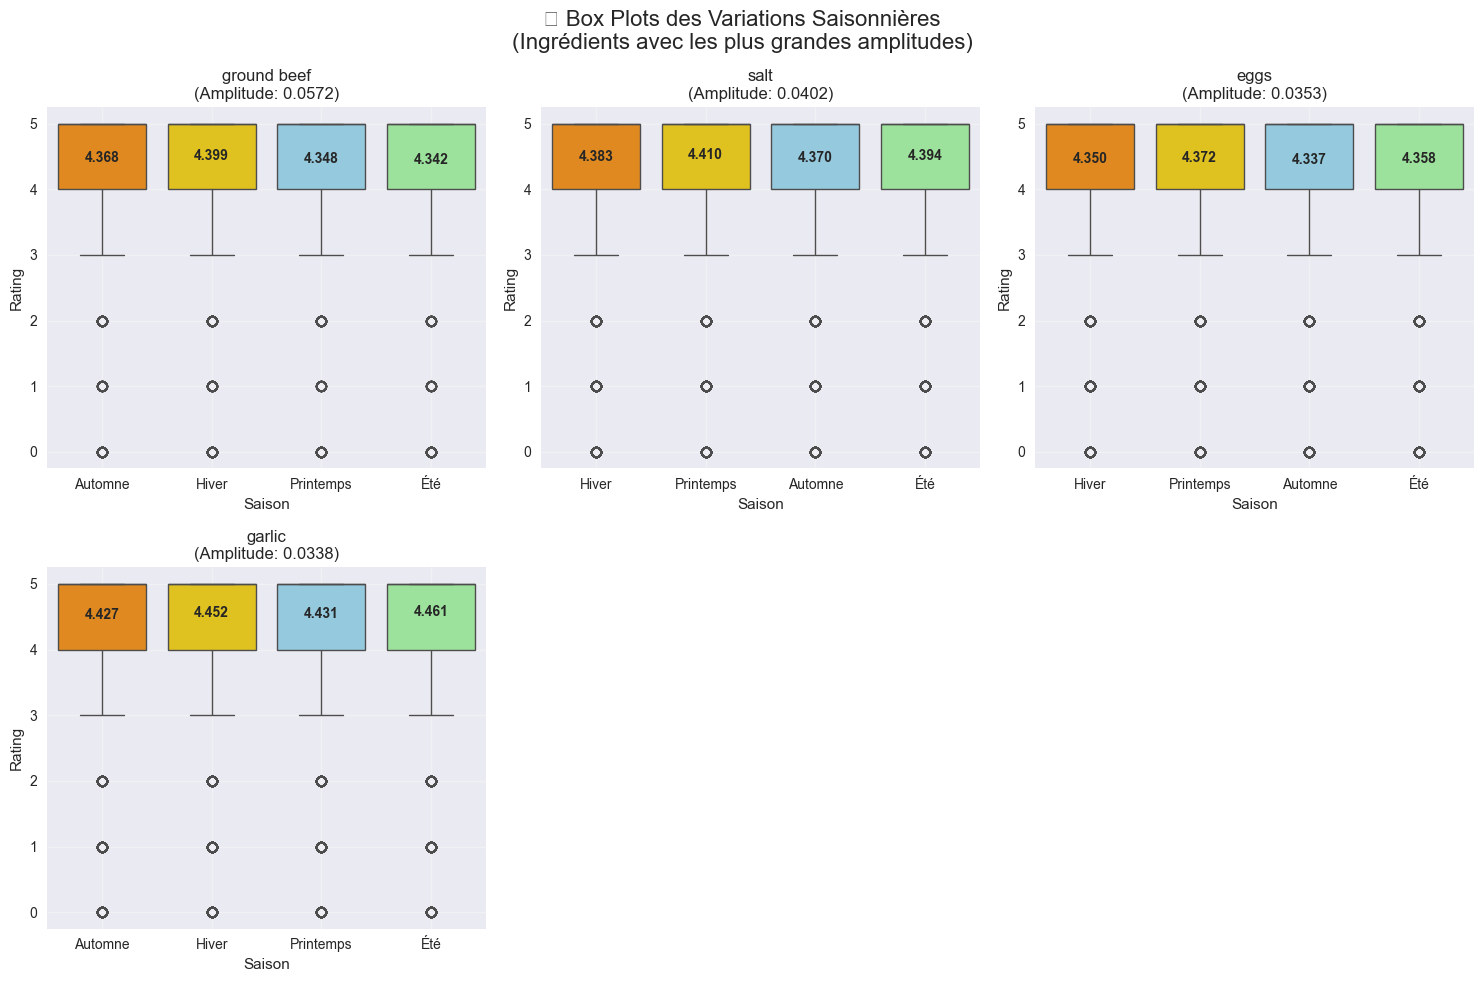

✅ Box plots saisonniers créés


In [10]:
# Visualisation 1: Box plots saisonniers
print('📊 Création des visualisations saisonnières...')

# Sélection des ingrédients les plus intéressants (avec variations significatives)
top_seasonal_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(6)['ingredient'].to_list()

if len(top_seasonal_ingredients) > 0:
    # Création des subplots
    n_ingredients = len(top_seasonal_ingredients)
    n_cols = 3
    n_rows = (n_ingredients + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, ingredient in enumerate(top_seasonal_ingredients):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # Données pour cet ingrédient
        ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
        
        # Conversion en pandas pour seaborn
        plot_data = ingredient_data.select(['season', 'rating']).to_pandas()
        
        # Box plot avec couleurs saisonnières
        sns.boxplot(data=plot_data, x='season', y='rating', ax=ax,
                   palette=[SEASON_COLORS[season] for season in ['Automne', 'Été', 'Hiver', 'Printemps']])
        
        # Ajout des moyennes
        season_means = plot_data.groupby('season')['rating'].mean()
        for j, season in enumerate(['Automne', 'Été', 'Hiver', 'Printemps']):
            if season in season_means.index:
                ax.text(j, season_means[season], f'{season_means[season]:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax.set_title(f'{ingredient}\n(Amplitude: {significant_seasonal.filter(pl.col("ingredient") == ingredient)["seasonal_range"].item():.4f})')
        ax.set_xlabel('Saison')
        ax.set_ylabel('Rating')
        ax.grid(True, alpha=0.3)
    
    # Masquer les axes vides
    for i in range(len(top_seasonal_ingredients), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.suptitle('🌱 Box Plots des Variations Saisonnières\n(Ingrédients avec les plus grandes amplitudes)', 
                fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print('✅ Box plots saisonniers créés')
else:
    print('⚠️  Aucune variation saisonnière significative détectée')

🕷️ Création du radar chart saisonnier...


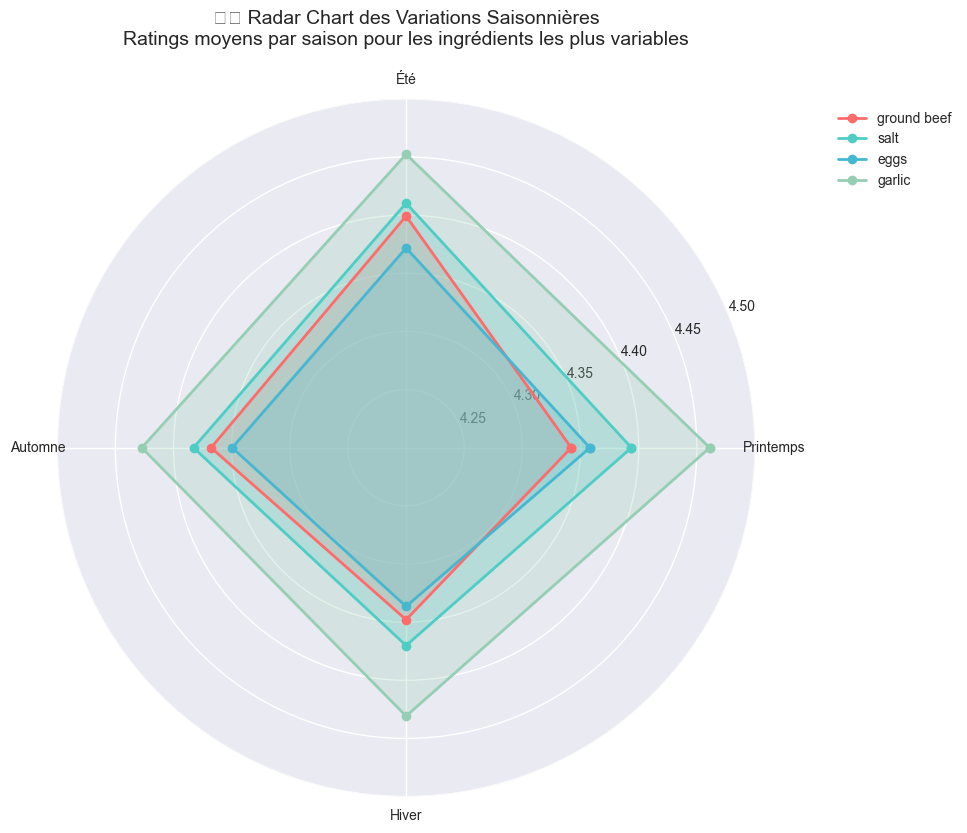

✅ Radar chart saisonnier créé


In [12]:
# Visualisation 2: Radar chart saisonnier avec matplotlib
if len(significant_seasonal) > 0:
    print('🕷️ Création du radar chart saisonnier...')
    
    # Sélection des 4 ingrédients les plus variables
    radar_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(4)['ingredient'].to_list()
    
    # Configuration du radar chart
    import math
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    seasons_order = ['Printemps', 'Été', 'Automne', 'Hiver']
    angles = [n / float(len(seasons_order)) * 2 * math.pi for n in range(len(seasons_order))]
    angles += angles[:1]  # Fermer le polygone
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, ingredient in enumerate(radar_ingredients):
        # Récupération des moyennes saisonnières
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        
        values = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        values += values[:1]  # Fermer le polygone
        
        ax.plot(angles, values, 'o-', linewidth=2, label=ingredient, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Configuration des axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(seasons_order)
    ax.set_ylim(4.2, 4.5)  # Ajuster selon les données
    ax.set_title('🕷️ Radar Chart des Variations Saisonnières\nRatings moyens par saison pour les ingrédients les plus variables', 
                 size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    print('✅ Radar chart saisonnier créé')
else:
    print('⚠️  Pas assez de données pour le radar chart')

🔥 Création de la heatmap saisonnière...


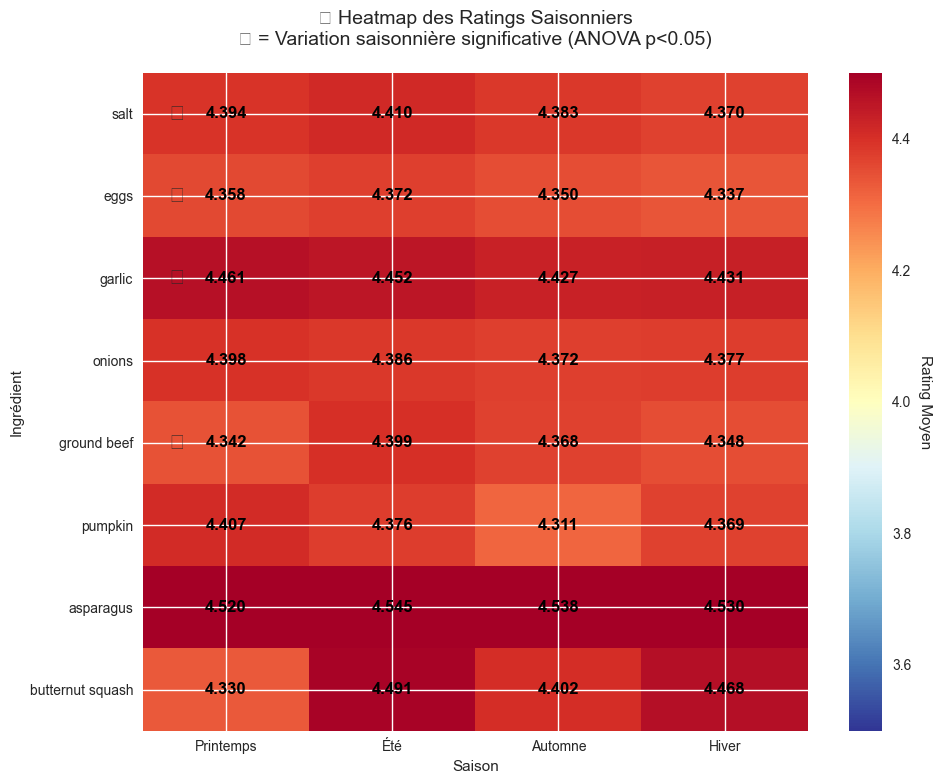

✅ Heatmap saisonnière créée


In [13]:
# Visualisation 3: Heatmap des moyennes saisonnières
print('🔥 Création de la heatmap saisonnière...')

# Préparation de la matrice des moyennes
heatmap_data = []
heatmap_ingredients = []

for ingredient in complete_ingredients:
    ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient)
    if len(ingredient_row) > 0:
        row_data = ingredient_row.row(0, named=True)
        heatmap_data.append([
            row_data['spring_avg'],
            row_data['summer_avg'],
            row_data['autumn_avg'],
            row_data['winter_avg']
        ])
        heatmap_ingredients.append(ingredient)

# Création de la heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=3.5, vmax=4.5)

# Configuration des axes
seasons = ['Printemps', 'Été', 'Automne', 'Hiver']
ax.set_xticks(range(len(seasons)))
ax.set_xticklabels(seasons)
ax.set_yticks(range(len(heatmap_ingredients)))
ax.set_yticklabels(heatmap_ingredients)

# Ajout des valeurs dans les cellules
for i in range(len(heatmap_ingredients)):
    for j in range(len(seasons)):
        value = heatmap_data[i][j]
        # Couleur du texte selon l'intensité
        text_color = 'white' if value < 4.0 else 'black'
        text = ax.text(j, i, f'{value:.3f}',
                      ha="center", va="center", color=text_color, fontweight='bold')

# Ajout d'étoiles pour les variations significatives
for i, ingredient in enumerate(heatmap_ingredients):
    if ingredient in significant_seasonal['ingredient'].to_list():
        ax.text(-0.3, i, '⭐', ha="center", va="center", fontsize=16)

# Colorbar et titre
cbar = plt.colorbar(im)
cbar.set_label('Rating Moyen', rotation=270, labelpad=15)

plt.title('🔥 Heatmap des Ratings Saisonniers\n⭐ = Variation saisonnière significative (ANOVA p<0.05)', 
         fontsize=14, pad=20)
plt.xlabel('Saison')
plt.ylabel('Ingrédient')
plt.tight_layout()
plt.show()

print('✅ Heatmap saisonnière créée')

In [14]:
# Analyse des patterns saisonniers
print('🔍 Analyse des patterns saisonniers...')

if len(significant_seasonal) > 0:
    # Groupement par saison préférée
    seasonal_preferences = significant_seasonal.group_by('best_season').agg([
        pl.col('ingredient').count().alias('n_ingredients'),
        pl.col('ingredient').alias('ingredients_list')
    ]).sort('n_ingredients', descending=True)
    
    print('🌱 Répartition des préférences saisonnières:')
    for row in seasonal_preferences.iter_rows(named=True):
        season_emoji = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}
        emoji = season_emoji.get(row['best_season'], '🌿')
        print(f"{emoji} {row['best_season']}: {row['n_ingredients']} ingrédients")
        ingredients_str = ', '.join(row['ingredients_list'])
        print(f"   → {ingredients_str}")
    
    # Analyse des amplitudes saisonnières
    print(f'\n📊 Statistiques des amplitudes saisonnières:')
    amplitude_stats = significant_seasonal.select('seasonal_range')
    print(f'   • Amplitude moyenne: {amplitude_stats.mean().item():.4f}')
    print(f'   • Amplitude médiane: {amplitude_stats.median().item():.4f}')
    print(f'   • Amplitude max: {amplitude_stats.max().item():.4f}')
    print(f'   • Amplitude min: {amplitude_stats.min().item():.4f}')
    
    # Top ingrédients par amplitude
    print(f'\n🏆 Top 3 des ingrédients les plus variables:')
    top_variable = significant_seasonal.sort('seasonal_range', descending=True).head(3)
    for i, row in enumerate(top_variable.iter_rows(named=True), 1):
        print(f"   {i}. {row['ingredient']}: amplitude = {row['seasonal_range']:.4f} " +
              f"(meilleure saison: {row['best_season']})")
else:
    print('⚠️  Aucune variation saisonnière significative pour analyse approfondie')

🔍 Analyse des patterns saisonniers...
🌱 Répartition des préférences saisonnières:
🌿 Summer: 3 ingrédients
   → salt, eggs, ground beef
🌿 Spring: 1 ingrédients
   → garlic

📊 Statistiques des amplitudes saisonnières:
   • Amplitude moyenne: 0.0416
   • Amplitude médiane: 0.0377
   • Amplitude max: 0.0572
   • Amplitude min: 0.0338

🏆 Top 3 des ingrédients les plus variables:
   1. ground beef: amplitude = 0.0572 (meilleure saison: Summer)
   2. salt: amplitude = 0.0402 (meilleure saison: Summer)
   3. eggs: amplitude = 0.0353 (meilleure saison: Summer)


In [15]:
# Recommandations stratégiques
print('💡 RECOMMANDATIONS STRATÉGIQUES SAISONNIÈRES')
print('='*60)

if len(significant_seasonal) > 0:
    print('\n🎯 STRATÉGIES PAR SAISON:')
    
    for season in ['Printemps', 'Été', 'Automne', 'Hiver']:
        season_champions = significant_seasonal.filter(pl.col('best_season') == season)
        if len(season_champions) > 0:
            season_emoji = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}[season]
            print(f'\n{season_emoji} {season.upper()}:')
            
            for row in season_champions.iter_rows(named=True):
                seasonal_boost = row['seasonal_range']
                print(f'   • Mettre en avant: {row["ingredient"]} (boost de +{seasonal_boost:.4f})')
    
    print(f'\n📈 INSIGHTS BUSINESS:')
    total_seasonal_ingredients = len(significant_seasonal)
    print(f'   • {total_seasonal_ingredients} ingrédients montrent des préférences saisonnières')
    print(f'   • Opportunité de personnalisation saisonnière des menus')
    print(f'   • Potentiel d\'augmentation des ratings par adaptation temporelle')
    
    # Saison la plus favorable globalement
    if len(seasonal_preferences) > 0:
        top_season = seasonal_preferences.row(0, named=True)
        print(f'   • Saison la plus favorable: {top_season["best_season"]} ({top_season["n_ingredients"]} ingrédients)')
else:
    print('\n➡️  CONCLUSION:')
    print('   • Les ingrédients analysés ne montrent pas de variations saisonnières marquées')
    print('   • Les préférences utilisateurs semblent stables au fil des saisons')
    print('   • Focus possible sur d\'autres axes temporels (long-terme, weekend)')

print(f'\n✅ Analyse saisonnière terminée avec succès!')

💡 RECOMMANDATIONS STRATÉGIQUES SAISONNIÈRES

🎯 STRATÉGIES PAR SAISON:

📈 INSIGHTS BUSINESS:
   • 4 ingrédients montrent des préférences saisonnières
   • Opportunité de personnalisation saisonnière des menus
   • Potentiel d'augmentation des ratings par adaptation temporelle
   • Saison la plus favorable: Summer (3 ingrédients)

✅ Analyse saisonnière terminée avec succès!


In [16]:
# Synthèse finale
print('📋 SYNTHÈSE DE L\'ANALYSE SAISONNIÈRE')
print('='*60)

print(f'\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Ingrédients analysés: {len(complete_ingredients)}')
print(f'   • Ingrédients avec couverture complète (4 saisons): {len(complete_ingredients)}')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')

print(f'\n📊 RÉSULTATS STATISTIQUES:')
if len(anova_df) > 0:
    significant_count = len(significant_seasonal)
    print(f'   • Test ANOVA réalisé sur {len(anova_df)} ingrédients')
    print(f'   • Variations saisonnières significatives: {significant_count}/{len(anova_df)}')
    
    if significant_count > 0:
        avg_amplitude = significant_seasonal['seasonal_range'].mean()
        print(f'   • Amplitude moyenne des variations: {avg_amplitude:.4f}')
        
        # Distribution des saisons préférées
        if len(seasonal_preferences) > 0:
            print(f'   • Répartition des préférences:')
            for row in seasonal_preferences.iter_rows(named=True):
                print(f'     - {row["best_season"]}: {row["n_ingredients"]} ingrédients')
    else:
        print(f'   • Aucune variation saisonnière significative détectée')
else:
    print(f'   • Aucun test statistique réalisé (données insuffisantes)')

print(f'\n🎯 APPLICATIONS PRATIQUES:')
print(f'   • Optimisation des menus saisonniers')
print(f'   • Personnalisation temporelle des recommandations')
print(f'   • Stratégies marketing adaptées aux saisons')
print(f'   • Gestion des stocks selon les préférences temporelles')

print(f'\n✅ Analyse saisonnière complète et prête pour exploitation!')

📋 SYNTHÈSE DE L'ANALYSE SAISONNIÈRE

🔍 DONNÉES ANALYSÉES:
   • Ingrédients analysés: 8
   • Ingrédients avec couverture complète (4 saisons): 8
   • Période: 2000-01-25 → 2018-12-20
   • Total interactions: 845,309

📊 RÉSULTATS STATISTIQUES:
   • Test ANOVA réalisé sur 8 ingrédients
   • Variations saisonnières significatives: 4/8
   • Amplitude moyenne des variations: 0.0416
   • Répartition des préférences:
     - Summer: 3 ingrédients
     - Spring: 1 ingrédients

🎯 APPLICATIONS PRATIQUES:
   • Optimisation des menus saisonniers
   • Personnalisation temporelle des recommandations
   • Stratégies marketing adaptées aux saisons
   • Gestion des stocks selon les préférences temporelles

✅ Analyse saisonnière complète et prête pour exploitation!
